### Correlation between alpha-diversity of  microbiome data and environmental factors 
---

In [1]:
#setworking directory to AbioticAraMicrobe/
setwd('../')

In [2]:
#load packages
library(reshape2)
library(vegan)
library(dplyr)
library(ggplot2)
library(ggpubr)
library(leaps)
library(phyloseq)

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-2


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
#preapare environmental factor as a raw data and normalize one. both in spread form which environmental factors are in different columns and the valus are identical based on different "site_season_year"
library(tidyr)
env_data <- read.table("data/environmental_data.txt" , header = TRUE)
env_data <- separate(data = env_data , col = variable , into = c("Month1" , "Season") , sep = "_" , remove = FALSE)
d1 <- data.frame("envdata"=unique(env_data$env_factor))
#add full names of env factors
d1$environmentalfactor <- c("Precipitation" , "Vapor_Pressure_Deficit" , "Palmer_Drought_Severity_Index" , "Soil_Moisture" , "Runoff" , "Downward_Surface_Shortwave_Radiation" , "Climate_Water_Deficit" , "Actual_Evapotranspiration" , "Vapor_Pressure" , 
                            "Min_Temperature" , "Snow_Water_Equivalent" , "Potential_Evapotranspiration" , "Max_Temperature" , "Wind_Speed")
d1$environmentalfactor = gsub("Downward_Surface_Shortwave_Radiation" ,"Radiation" , d1$environmentalfactor)
d1$environmentalfactor = gsub("Palmer_Drought_Severity_Index" ,"Drought" , d1$environmentalfactor)
head(d1)

env_data <- merge(env_data , d1 , by.x = "env_factor" , by.y = "envdata")
env_data$env_value = env_data$value
env_data$season_site <- paste(env_data$Season,env_data$Site)
env_data$site_season_year = paste(env_data$Site , env_data$Season , env_data$Year , sep = "_" )###########################################data1
env_data$site_season_year_env = paste(env_data$Site , env_data$Season , env_data$Year,env_data$environmentalfactor , sep = "_" )
#head(env_data)

#spread env data in different columns
env_data_count <- env_data[c("site_season_year" , "environmentalfactor" , "env_value")] %>% spread(environmentalfactor,env_value) ########################data2
#head(env_data_count)

#normalized env data 
#normalize the environmental data , first group them then do normalization this is z transformation 
stdize=function(x) {(x - mean(x))/sd(x)}
#stdize=function(x) {log10((x/sum(x))+1)}
env_data_norm <- data.frame(env_data_count[1] , apply(env_data_count[2:ncol(env_data_count)] ,2, stdize)) #2 is the margin , apply on the columns ########################data3
#env_data_norm = env_data_count
#head(env_data_norm)
env_data_melt <- melt(env_data_norm ,id ="site_season_year" ,   variable.name = "env_factor" , value.name = "env_value_norm")
env_data_melt$site_season_year_env = paste(env_data_melt$site_season_year,env_data_melt$env_factor , sep = "_" )
env_data_melt <- merge(y =env_data[c("Site" , "Season" , "Year" , "env_value"  , "season_site" ,"site_season_year_env")],x=env_data_melt , by = "site_season_year_env") #########################data4
#head(env_data_melt)
#load microbiome data




Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths




envdata environmentalfactor   
1 ppt     Precipitation         
2 vpd     Vapor_Pressure_Deficit
3 PDSI    Drought               
4 soil    Soil_Moisture         
5 q       Runoff                
6 srad    Radiation

[1] 924   9

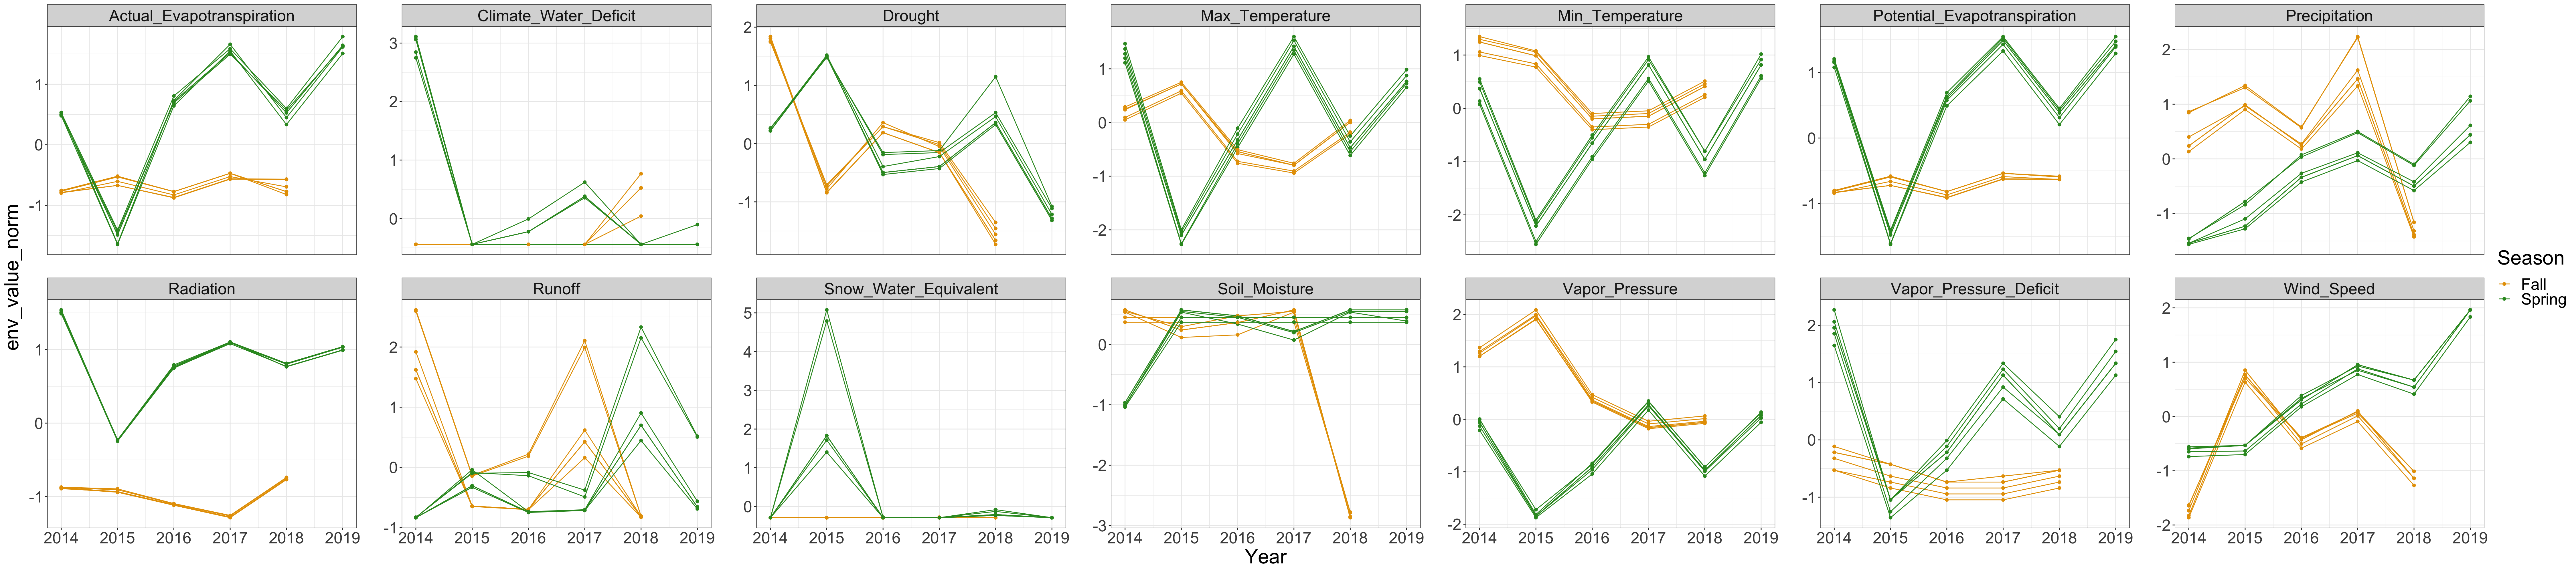

In [4]:
#plot normmalize env data over years (using env_data_melt)
dim(env_data_melt)
p1 = ggplot(env_data_melt, aes(y = env_value_norm, x = Year   , group = season_site , color =Season))  +  
    geom_line()+geom_point() + facet_wrap(~ env_factor,nrow = 2 , scales="free_y" ) + theme_bw() + theme(text=element_text(size=25) , 
                                                                                                       panel.spacing = unit(2, "lines")) +
scale_color_manual(values=c("#E69F00", "#309627"))

options(repr.plot.width = 45, repr.plot.height =10, repr.plot.res = 200 )
p1
ggsave("plots/environmentalfactors_barplot.pdf" , p1, width = 45, height = 10) 

site_season_year_env                       site_season_year
1 ERG_Fall_2014_Actual_Evapotranspiration    ERG_Fall_2014   
2 ERG_Fall_2014_Climate_Water_Deficit        ERG_Fall_2014   
3 ERG_Fall_2014_Drought                      ERG_Fall_2014   
4 ERG_Fall_2014_Max_Temperature              ERG_Fall_2014   
5 ERG_Fall_2014_Min_Temperature              ERG_Fall_2014   
6 ERG_Fall_2014_Potential_Evapotranspiration ERG_Fall_2014   
  env_factor                   env_value_norm Site Season Year env_value
1 Actual_Evapotranspiration    -0.79264527    ERG  Fall   2014 16.90    
2 Climate_Water_Deficit        -0.44148181    ERG  Fall   2014  0.00    
3 Drought                       1.75890428    ERG  Fall   2014  2.48    
4 Max_Temperature               0.05012492    ERG  Fall   2014  9.83    
5 Min_Temperature               0.99069671    ERG  Fall   2014  3.45    
6 Potential_Evapotranspiration -0.83417305    ERG  Fall   2014 16.90    
  season_site
1 Fall ERG   
2 Fall ERG   
3 Fall ERG   
4 Fall ERG   
5 Fall ERG   
6 Fall ERG

Warning message:
“The dot-dot notation (`..p.signif..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(p.signif)` instead.”


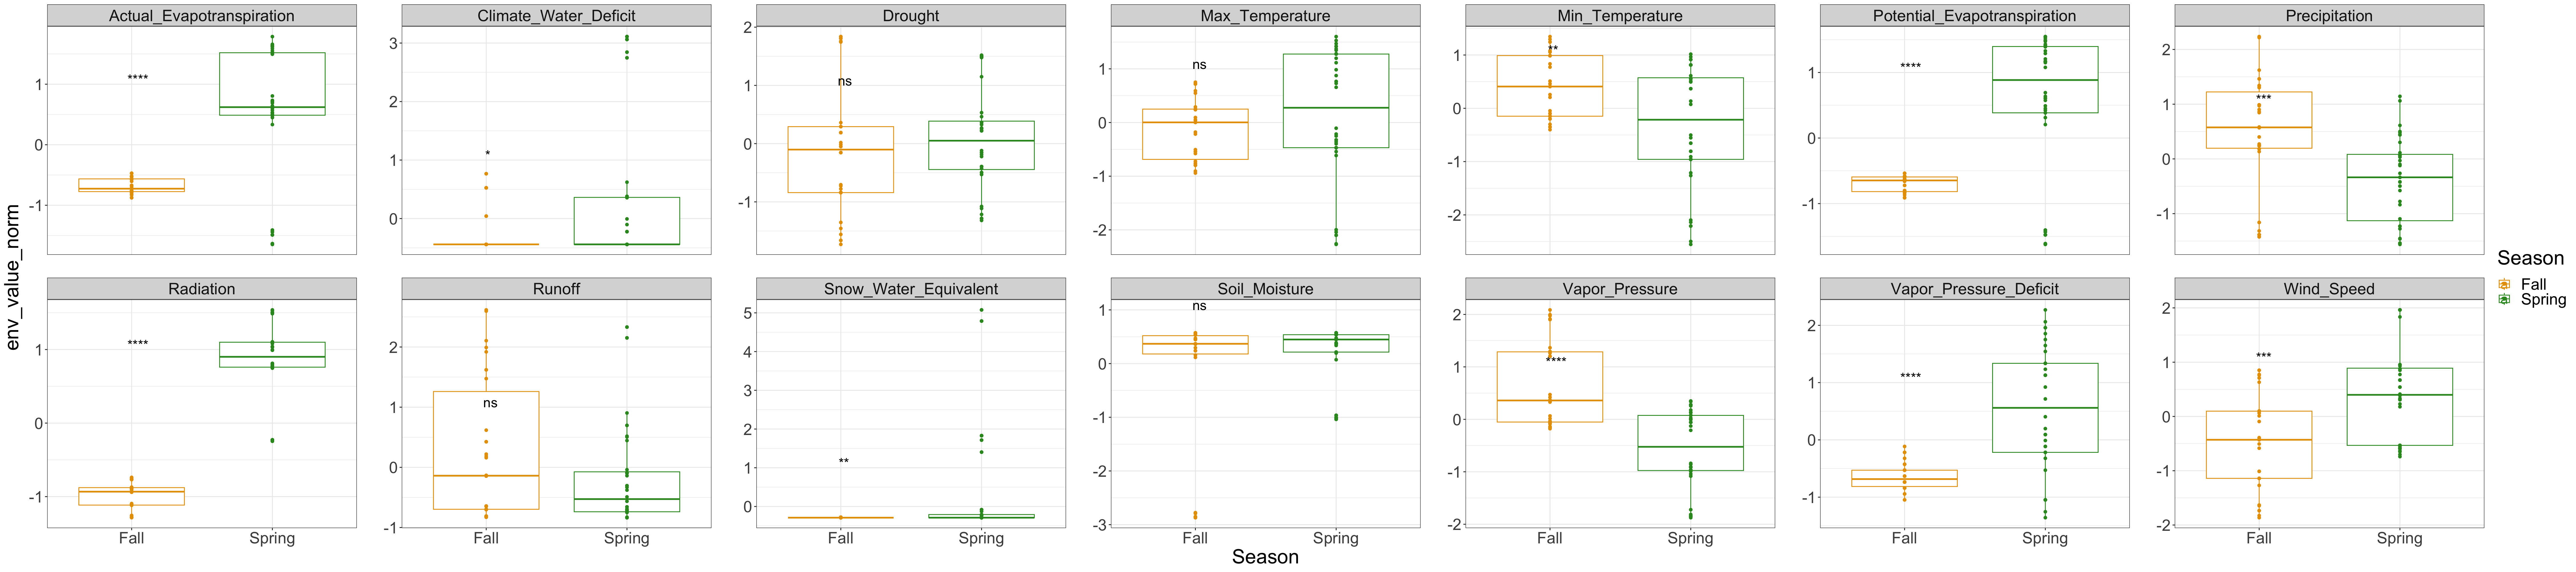

In [5]:
#plot normmalize env data over years (using env_data_melt)
head(env_data_melt)
p1 = ggplot(env_data_melt, aes(y = env_value_norm, x = Season   , group = Season , color =Season))  +  
    geom_boxplot()+geom_point() + facet_wrap(~ env_factor,nrow = 2 , scales="free_y" ) + theme_bw() + theme(text=element_text(size=25) , 
                                                                                                       panel.spacing = unit(2, "lines")) +
scale_color_manual(values=c("#E69F00", "#309627")) + stat_compare_means(method = "wilcox.test" , label = "p.signif" , size = 6 , label.y = 1)

options(repr.plot.width = 45, repr.plot.height =10, repr.plot.res = 200 )
p1
ggsave("plots/environmentalfactors_boxplot.pdf" , p1, width = 45, height = 10)

----
### calculate alpha diversity and combine the data with environmental factor

In [19]:

#Bacteria alpha diversity
#open otu table
Otu1 = read.table("data/DataClean/BV5Otu.txt", header = T , check.names = F , stringsAsFactors = F)
rownames(Otu1) = Otu1$Samplenumber
n = which(colnames(Otu1)=='Otu000002')  
n
sam_otu = Otu1[-c(1:14)] #n-1 
sam_otu = sam_otu[rowSums(sam_otu)!=0,]
sample = Otu1[c(1:14)] #n-1
sample = sample[rownames(sample) %in% rownames(sam_otu),]
identical(row.names(sample),row.names(sam_otu)) 

#make phyloseq input files
otusam <- otu_table(sam_otu , taxa_are_rows = FALSE,errorIfNULL = TRUE)
samples <- sample_data(sample)
file <- phyloseq(otusam,samples)

#mesure alpha diversity
rich = estimate_richness(file,measures = c("Observed", "Chao1", "Shannon"))
rich = select(rich , -c(3))
rich1 = merge(rich,data.frame(sample_data(file)),by=0)
richB = select(rich1 , -c(1))
richB$Taxa = 'Bacteria'
head(env_data_melt)
#---------------------------------------------------------------------------------------------
#For Fungi
Otu1 = read.table("data/DataClean/FITS2Otu.txt", header = T , check.names = F , stringsAsFactors = F)
rownames(Otu1) = Otu1$Samplenumber
n = which(colnames(Otu1)=='Otu00002') 
n

sam_otu = Otu1[-c(1:14)] #n-1
sam_otu = sam_otu[rowSums(sam_otu)!=0,]
sample = Otu1[c(1:14)] #n-1
sample = sample[rownames(sample) %in% rownames(sam_otu),]
identical(row.names(sample),row.names(sam_otu)) 
#make phyloseq input files

#otu-sample matrix
#phloseqfiles
otusam <- otu_table(sam_otu , taxa_are_rows = FALSE,errorIfNULL = TRUE)
samples <- sample_data(sample)
file <- phyloseq(otusam,samples)

rich = estimate_richness(file,measures = c("Observed", "Chao1", "Shannon"))
rich = select(rich , -c(3))
rich1 = merge(rich,data.frame(sample_data(file)),by=0)
richF = select(rich1 , -c(1))
richF$Taxa = 'Fungi'

#---------------------------------------------------------------------------------------------
#For Eukaryotes

Otu1 = read.table("data/DataClean/PV9Otu.txt", header = T , check.names = F , stringsAsFactors = F)
rownames(Otu1) = Otu1$Samplenumber
n = which(colnames(Otu1)=='Otu00002') 
n

sam_otu = Otu1[-c(1:14)] #n-1
sam_otu = sam_otu[rowSums(sam_otu)!=0,]
sample = Otu1[c(1:14)] #n-1
sample = sample[rownames(sample) %in% rownames(sam_otu),]
identical(row.names(sample),row.names(sam_otu)) 
#make phyloseq input files

#otu-sample matrix
#phloseqfiles
otusam <- otu_table(sam_otu , taxa_are_rows = FALSE,errorIfNULL = TRUE)
samples <- sample_data(sample)
file <- phyloseq(otusam,samples)


rich = estimate_richness(file,measures = c("Observed", "Chao1", "Shannon"))
rich = select(rich , -c(3))
rich1 = merge(rich,data.frame(sample_data(file)),by=0)
richE = select(rich1 , -c(1))
richE$Taxa = 'Eukaryotes'

#--------------------------------------------------------------------------------------------------
#combine files
div = rbind(richB , richF ,richE)
div$site_season_year = paste(div$Site,div$Season,div$Year, sep = '_')

df = merge(div, env_data_melt , by = 'site_season_year' )
df$Taxa = factor(df$Taxa, levels=c('Bacteria' ,'Fungi' , 'Eukaryotes'))
head(df)

[1] 15

[1] TRUE

site_season_year_env                       site_season_year
1 ERG_Fall_2014_Actual_Evapotranspiration    ERG_Fall_2014   
2 ERG_Fall_2014_Climate_Water_Deficit        ERG_Fall_2014   
3 ERG_Fall_2014_Drought                      ERG_Fall_2014   
4 ERG_Fall_2014_Max_Temperature              ERG_Fall_2014   
5 ERG_Fall_2014_Min_Temperature              ERG_Fall_2014   
6 ERG_Fall_2014_Potential_Evapotranspiration ERG_Fall_2014   
  env_factor                   env_value_norm Site Season Year env_value
1 Actual_Evapotranspiration    -0.79264527    ERG  Fall   2014 16.90    
2 Climate_Water_Deficit        -0.44148181    ERG  Fall   2014  0.00    
3 Drought                       1.75890428    ERG  Fall   2014  2.48    
4 Max_Temperature               0.05012492    ERG  Fall   2014  9.83    
5 Min_Temperature               0.99069671    ERG  Fall   2014  3.45    
6 Potential_Evapotranspiration -0.83417305    ERG  Fall   2014 16.90    
  season_site
1 Fall ERG   
2 Fall ERG   
3 Fall ERG   
4 Fall ERG   
5 Fall ERG   
6 Fall ERG

[1] 15

[1] TRUE

[1] 15

[1] TRUE

site_season_year Observed Chao1 Shannon  Lib Run Samplenumber Site.x Season.x
1 ERG_Fall_2014    19       19.75 1.913279 G34 G   S32          ERG    Fall    
2 ERG_Fall_2014    19       19.75 1.913279 G34 G   S32          ERG    Fall    
3 ERG_Fall_2014    19       19.75 1.913279 G34 G   S32          ERG    Fall    
4 ERG_Fall_2014    19       19.75 1.913279 G34 G   S32          ERG    Fall    
5 ERG_Fall_2014    19       19.75 1.913279 G34 G   S32          ERG    Fall    
6 ERG_Fall_2014    19       19.75 1.913279 G34 G   S32          ERG    Fall    
  Year.x ⋯ numOTUs Taxa  site_season_year_env                   
1 2014   ⋯ 2144    Fungi ERG_Fall_2014_Actual_Evapotranspiration
2 2014   ⋯ 2144    Fungi ERG_Fall_2014_Runoff                   
3 2014   ⋯ 2144    Fungi ERG_Fall_2014_Climate_Water_Deficit    
4 2014   ⋯ 2144    Fungi ERG_Fall_2014_Drought                  
5 2014   ⋯ 2144    Fungi ERG_Fall_2014_Wind_Speed               
6 2014   ⋯ 2144    Fungi ERG_Fall_2014_Radiation                
  env_factor                env_value_norm Site.y Season.y Year.y env_value
1 Actual_Evapotranspiration -0.7926453     ERG    Fall     2014   16.90000 
2 Runoff                     2.5965657     ERG    Fall     2014   52.40000 
3 Climate_Water_Deficit     -0.4414818     ERG    Fall     2014    0.00000 
4 Drought                    1.7589043     ERG    Fall     2014    2.48000 
5 Wind_Speed                -1.6448317     ERG    Fall     2014    1.31000 
6 Radiation                 -0.8763182     ERG    Fall     2014   53.59962 
  season_site
1 Fall ERG   
2 Fall ERG   
3 Fall ERG   
4 Fall ERG   
5 Fall ERG   
6 Fall ERG

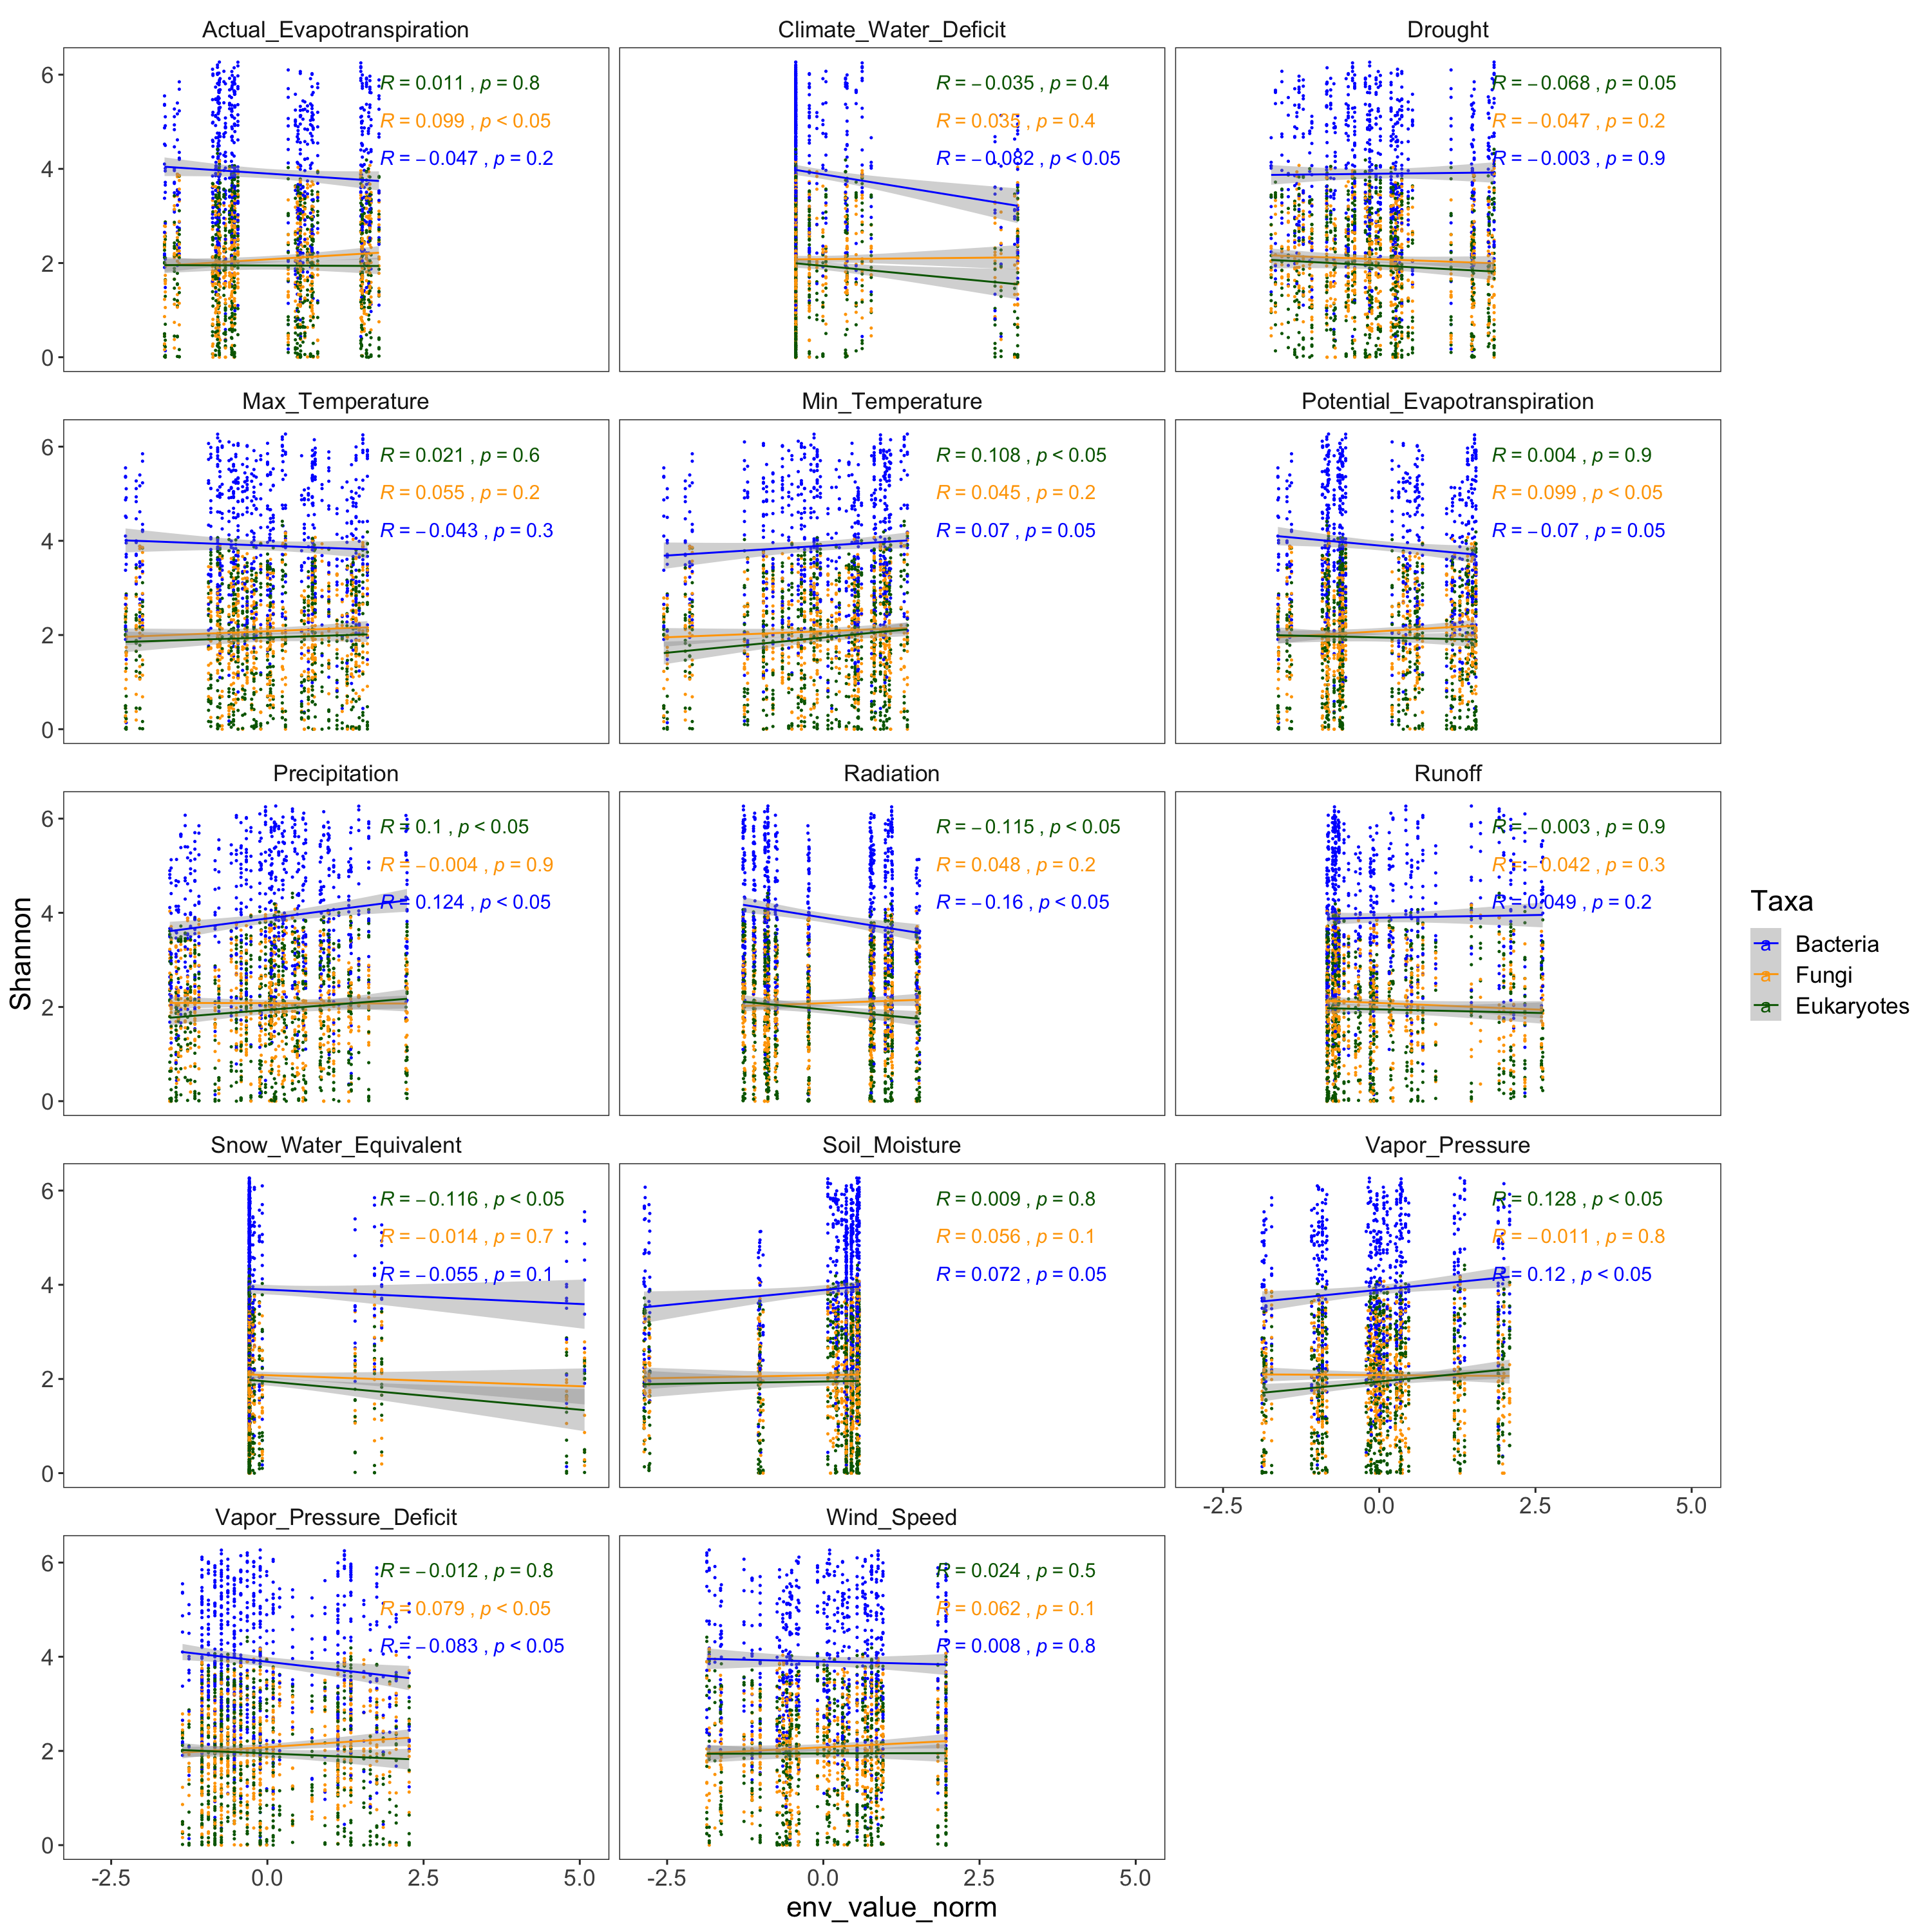

In [42]:
p = ggplot(df, aes(env_value_norm, Shannon ,  colour = Taxa)) +           
  geom_point(size = 0.2) +                                  
  stat_smooth(method = "lm",
              formula = y ~ x,
              geom = "smooth" ,size = 0.5) + facet_wrap(.~env_factor , nrow =5)  + scale_colour_manual(values = c("blue", "orange" , "darkgreen")) + theme_bw() + 
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank() , strip.background = element_blank() , text = element_text(size = 16)) + 
stat_cor(method = "spearman", label.x = 1.8, label.y = c(4.2,5,5.8), p.accuracy = 0.05, r.accuracy = 0.001 ,  aes(label = paste(..r.label.., ..p.label.., sep = "~`,`~"))) 

ggsave("plots/alpha_diversity_environmentalfactor.pdf",p , width = 14 , height = 14)
options(repr.plot.width=15, repr.plot.height=15)
p



In [36]:
(nrow(p$data))/14
2087/3

[1] 2087

[1] 695.6667